from this [video](https://www.youtube.com/watch?v=BQLvNLgMTQE) and [code](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/lid_driven_cavity_python_simple.py)

also [dr zgan's cfd course notes](https://drzgan.github.io/Python_CFD/15.2.%20Cavity%20flow%20with%20Chorin%27s%20Projection.html)

# Procedure

## 1) Tentative Velocity Field
Solve momentum equation w/o pressure gradient

\begin{split}
\frac{\partial \vec{v}^*}{\partial t}+(\vec{v}^*\cdot\nabla)\vec{v}^*= \nu \nabla^2\vec{v}^*
\end{split}

## 2) Poisson Equation for Pressure
Keep in mind the boundary conditions for this step
\begin{split}
\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = \rho\left(\frac{\partial}{\partial t}\left(\frac{\partial u^*}{\partial x} +\frac{\partial v^*}{\partial y} \right)  \right)
\end{split}

## 3) Velocity Corrections
Keep in mind the boundary conditions for this step
\begin{split}
u = u^* - \frac{\Delta t}{\rho} \frac{\partial p}{\partial x}\\
v = v^* - \frac{\Delta t}{\rho} \frac{\partial p}{\partial y}
\end{split}

# Boundary Conditions
For lid driven cavity flow:
$u = 1$ @ $y=2$ (The lid)

$u,v=0$ at all other boundaries

$\frac{\partial p}{\partial y} = 0$ at $y=0$, and $\frac{\partial p}{\partial x}=0$ at $x=0,2$ (No pressure gradient at non "driven" boundaries)

In [151]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import time

In [152]:
N_POINTS = 11
DOMAIN_SIZE = 1.0
N_ITERATIONS = 1  # for explicit timestep
TIME_STEP_LENGTH = 0.01
KINEMATIC_VISCOSITY = 0.1
DENSITY = 1.0
HORIZONTAL_VELOCITY_TOP = 2.0  # in the positive x direction
N_PRESSURE_POISSON_ITERATIONS = 50

ELEMENT_LENGTH = DOMAIN_SIZE / (N_POINTS - 1)

In [153]:
def central_difference_x(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 2:] - f[1:-1, 0:-2]
    ) / (2 * ELEMENT_LENGTH)
    return diff

def central_difference_y(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[2:, 1:-1] - f[0:-2, 1:-1]
    ) / (2 * ELEMENT_LENGTH)
    return diff

def laplace(f):
    """Five-point stencil for laplace"""
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 0:-2] + 
        f[0:-2, 1:-1] +
        f[1:-1, 2:] + 
        f[2:, 1:-1]
        - 4 * f[1:-1, 1:-1]
    ) / (ELEMENT_LENGTH**2)
    return diff

In [154]:
def main():
    element_length = DOMAIN_SIZE / (N_POINTS - 1)
    x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
    X, Y = np.meshgrid(x, y)

    u_prev = np.zeros_like(X)
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)

    u_prev[-1, :] = HORIZONTAL_VELOCITY_TOP

    maximum_possible_time_step_length_from_heat_eqn = (
        0.5 * ELEMENT_LENGTH**2 / KINEMATIC_VISCOSITY
    )
    if TIME_STEP_LENGTH > 0.5 * maximum_possible_time_step_length_from_heat_eqn:
        raise RuntimeError("might not be stable")

    for itr in tqdm(range(N_ITERATIONS)):
        print(itr)
        # Calculate derivatives
        d_u_prev__d_x = central_difference_x(u_prev)
        d_u_prev__d_y = central_difference_y(u_prev)
        d_v_prev__d_x = central_difference_x(v_prev)
        d_v_prev__d_y = central_difference_y(v_prev)
        laplace__u_prev = laplace(u_prev)
        laplace__v_prev = laplace(v_prev)

        # Solve tentative velocity field w/o pressure gradient
        u_tent = (
            u_prev
            + TIME_STEP_LENGTH * (
                -(u_prev * d_u_prev__d_x + v_prev * d_u_prev__d_y)
                + KINEMATIC_VISCOSITY * laplace__u_prev
            )
        )
        v_tent = (
            v_prev
            + TIME_STEP_LENGTH * (
                -(u_prev * d_v_prev__d_x + v_prev * d_v_prev__d_y)
                + KINEMATIC_VISCOSITY * laplace__v_prev
            )
        )

        # Enforce boundary conditions
        # Homogenous dirichlet BC everywhere, except for horizontal velocity at the top
        u_tent[0, :] = 0.0  # bottom 
        u_tent[:, 0] = 0.0  # left
        u_tent[:, -1] = 0.0  # right
        u_tent[-1, :] = HORIZONTAL_VELOCITY_TOP  # top
        v_tent[0, :] = 0.0  # bottom 
        v_tent[:, 0] = 0.0  # left
        v_tent[:, -1] = 0.0  # right
        v_tent[-1, :] = 0.0  # top

        # terms for divergence of field
        d_u_tent__d_x = central_difference_x(u_tent)
        d_v_tent__d_y = central_difference_y(v_tent)

        # pressure correction from solving pressure poisson eqn
        rhs = (DENSITY / TIME_STEP_LENGTH) * (d_u_tent__d_x + d_v_tent__d_y)
        for itr_p in range(N_PRESSURE_POISSON_ITERATIONS):
            p_next = np.zeros_like(p_prev)
            p_next[1:-1, 1:-1] = (1/4) * (
                p_prev[1:-1, 0:-2]
                + p_prev[0:-2, 1:-1]
                + p_prev[1:-1, 2:]
                + p_prev[2:, 1:-1]
                - ELEMENT_LENGTH**2 * rhs[1:-1, 1:-1]
            )
            # enforce pressure boundary conditions: 
            # homogenous neumann everywhere, except for the top which is homogenous direchlet
            p_next[:, -1] = p_next[:, -2]  # right
            p_next[0, :] = p_next[1, :]  # bottom
            p_next[:, 0] = p_next[:, 1]  # left
            p_next[-1, :] = 0  # top

            p_prev = p_next
        
        # pressure gradient
        d_p_next__d_x = central_difference_x(p_next)
        d_p_next__d_y = central_difference_y(p_next)

        # Velocity corrections (for incompressible fluid!)
        u_next = (
            u_tent - TIME_STEP_LENGTH / DENSITY * d_p_next__d_x
        )
        v_next = (
            v_tent - TIME_STEP_LENGTH / DENSITY * d_p_next__d_y
        )
        # Enforce boundary conditions
        # Homogenous dirichlet BC everywhere, except for horizontal velocity at the top
        u_next[0, :] = 0.0  # bottom 
        u_next[:, 0] = 0.0  # left
        u_next[:, -1] = 0.0  # right
        u_next[-1, :] = HORIZONTAL_VELOCITY_TOP  # top
        v_next[0, :] = 0.0  # bottom 
        v_next[:, 0] = 0.0  # left
        v_next[:, -1] = 0.0  # right
        v_next[-1, :] = 0.0  # top

        # 
        u_prev = u_next
        v_prev = v_next
        p_prev = p_next
    
    plt.figure()
    plt.contourf(X, Y, p_next)
    plt.colorbar()
    #plt.quiver(X, Y, u_next, v_next, color="black")
    plt.streamplot(X, Y, u_next, v_next, color="black")
    plt.show()

    return p_next, u_next, v_next, u_tent, v_tent

100%|██████████| 1/1 [00:00<00:00, 478.42it/s]


0


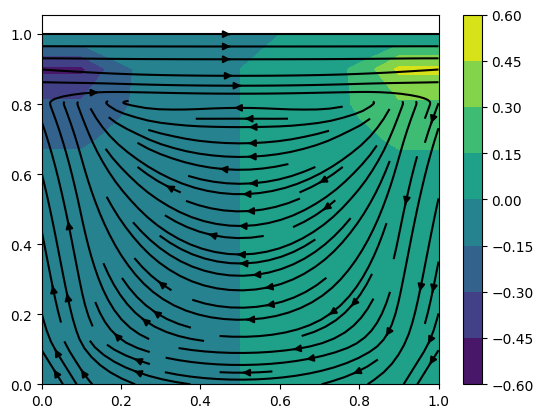

In [155]:
p_sol, u_sol, v_sol, u_tent, v_tent = main()

In [156]:
for line in u_tent:
    print(line)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0. ]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [157]:
for line in v_tent:
    print(line)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [158]:
for line in p_sol:
    for number in line:
        print(f"{number:7.3f}", end=" ")
        #print(f"{number:7.2f}", end=" ")
    print()
# Note that this code example never checked for convergence so this isn't actually converged.

 -0.019  -0.019  -0.016  -0.012  -0.006   0.000   0.006   0.012   0.016   0.019   0.019 
 -0.019  -0.019  -0.016  -0.012  -0.006   0.000   0.006   0.012   0.016   0.019   0.019 
 -0.023  -0.023  -0.020  -0.015  -0.008  -0.000   0.008   0.015   0.020   0.023   0.023 
 -0.032  -0.032  -0.028  -0.020  -0.011   0.000   0.011   0.020   0.028   0.032   0.032 
 -0.047  -0.047  -0.040  -0.029  -0.015   0.000   0.015   0.029   0.040   0.047   0.047 
 -0.071  -0.071  -0.060  -0.042  -0.021   0.000   0.021   0.042   0.060   0.071   0.071 
 -0.108  -0.108  -0.087  -0.058  -0.029   0.000   0.029   0.058   0.087   0.108   0.108 
 -0.168  -0.168  -0.124  -0.076  -0.036   0.000   0.036   0.076   0.124   0.168   0.168 
 -0.272  -0.272  -0.166  -0.089  -0.038   0.000   0.038   0.089   0.166   0.272   0.272 
 -0.484  -0.484  -0.181  -0.074  -0.028   0.000   0.028   0.074   0.181   0.484   0.484 
  0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000 


In [159]:
for line in u_sol:
    for number in line:
        print(f"{number:7.3f}", end=" ")
    print()

  0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000 
  0.000  -0.000  -0.000  -0.000  -0.001  -0.001  -0.001  -0.000  -0.000  -0.000   0.000 
  0.000  -0.000  -0.000  -0.001  -0.001  -0.001  -0.001  -0.001  -0.000  -0.000   0.000 
  0.000  -0.000  -0.001  -0.001  -0.001  -0.001  -0.001  -0.001  -0.001  -0.000   0.000 
  0.000  -0.000  -0.001  -0.001  -0.001  -0.001  -0.001  -0.001  -0.001  -0.000   0.000 
  0.000  -0.001  -0.001  -0.002  -0.002  -0.002  -0.002  -0.002  -0.001  -0.001   0.000 
  0.000  -0.001  -0.002  -0.003  -0.003  -0.003  -0.003  -0.003  -0.002  -0.001   0.000 
  0.000  -0.002  -0.005  -0.004  -0.004  -0.004  -0.004  -0.004  -0.005  -0.002   0.000 
  0.000  -0.005  -0.009  -0.006  -0.004  -0.004  -0.004  -0.006  -0.009  -0.005   0.000 
  0.000   0.185   0.180   0.192   0.196   0.197   0.196   0.192   0.180   0.185   0.000 
  2.000   2.000   2.000   2.000   2.000   2.000   2.000   2.000   2.000   2.000   2.000 


In [160]:
for line in v_sol:
    for number in line:
        print(f"{number:7.3f}", end=" ")
    print()

  0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000 
  0.000   0.000   0.000   0.000   0.000   0.000  -0.000  -0.000  -0.000  -0.000   0.000 
  0.000   0.001   0.001   0.000   0.000  -0.000  -0.000  -0.000  -0.001  -0.001   0.000 
  0.000   0.001   0.001   0.001   0.000  -0.000  -0.000  -0.001  -0.001  -0.001   0.000 
  0.000   0.002   0.002   0.001   0.001   0.000  -0.001  -0.001  -0.002  -0.002   0.000 
  0.000   0.003   0.002   0.001   0.001   0.000  -0.001  -0.001  -0.002  -0.003   0.000 
  0.000   0.005   0.003   0.002   0.001   0.000  -0.001  -0.002  -0.003  -0.005   0.000 
  0.000   0.008   0.004   0.002   0.000  -0.000  -0.000  -0.002  -0.004  -0.008   0.000 
  0.000   0.016   0.003  -0.000  -0.000   0.000   0.000   0.000  -0.003  -0.016   0.000 
  0.000  -0.014  -0.008  -0.004  -0.002   0.000   0.002   0.004   0.008   0.014   0.000 
  0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000 
